In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in ("X", "O", "Q")]
branch_defs = [
    (("X", "O", "Q"), 0.5, 1),
    (("X",), 0, 0.5),
    (("O", "Q"), 0.35, 0.5),
    (("O",), 0, 0.35),
    (("Q",), 0, 0.35)
]
# branch_defs = [(tuple(letters), 0, 1)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = table_dnn.MultitaskTabularNet(
    len(branch_defs), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

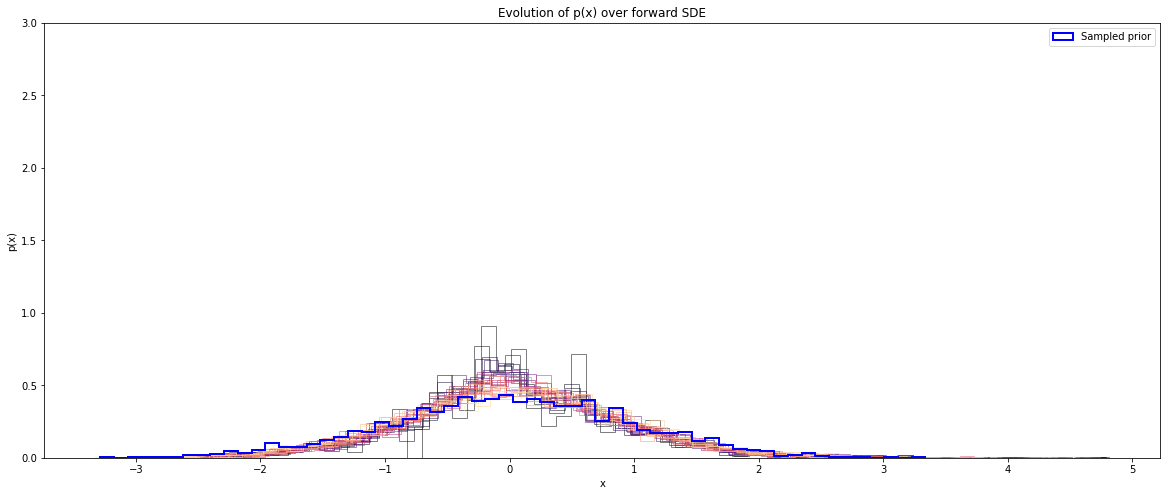

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 100,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "35"
Loss: 14.22: 100%|██████████████████████████████████████████| 19/19 [00:01<00:00, 16.25it/s]


Epoch 1 average Loss: 15.60


Loss: 12.24: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.71it/s]


Epoch 2 average Loss: 13.60


Loss: 12.14: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.54it/s]


Epoch 3 average Loss: 12.55


Loss: 11.73: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.82it/s]


Epoch 4 average Loss: 11.60


Loss: 11.26: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.88it/s]


Epoch 5 average Loss: 10.95


Loss: 11.64: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.95it/s]


Epoch 6 average Loss: 10.88


Loss: 9.65: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.00it/s]


Epoch 7 average Loss: 10.47


Loss: 9.94: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.40it/s]


Epoch 8 average Loss: 10.21


Loss: 9.37: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.44it/s]


Epoch 9 average Loss: 10.08


Loss: 10.10: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.72it/s]


Epoch 10 average Loss: 9.86


Loss: 8.11: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.78it/s]


Epoch 11 average Loss: 9.64


Loss: 10.12: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.55it/s]


Epoch 12 average Loss: 9.45


Loss: 10.25: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.26it/s]


Epoch 13 average Loss: 9.63


Loss: 9.91: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.43it/s]


Epoch 14 average Loss: 9.28


Loss: 8.53: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.52it/s]


Epoch 15 average Loss: 9.21


Loss: 9.93: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.43it/s]


Epoch 16 average Loss: 9.29


Loss: 9.32: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.77it/s]


Epoch 17 average Loss: 9.05


Loss: 9.90: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.67it/s]


Epoch 18 average Loss: 8.99


Loss: 9.74: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.96it/s]


Epoch 19 average Loss: 8.98


Loss: 9.21: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.81it/s]


Epoch 20 average Loss: 8.99


Loss: 8.21: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.66it/s]


Epoch 21 average Loss: 8.98


Loss: 9.73: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.34it/s]


Epoch 22 average Loss: 8.81


Loss: 8.81: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.53it/s]


Epoch 23 average Loss: 8.77


Loss: 10.16: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.34it/s]


Epoch 24 average Loss: 8.89


Loss: 9.09: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.88it/s]


Epoch 25 average Loss: 8.83


Loss: 8.11: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.00it/s]


Epoch 26 average Loss: 8.69


Loss: 9.58: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.85it/s]


Epoch 27 average Loss: 8.77


Loss: 11.25: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 23.32it/s]


Epoch 28 average Loss: 8.82


Loss: 10.67: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.68it/s]


Epoch 29 average Loss: 8.70


Loss: 10.00: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.15it/s]


Epoch 30 average Loss: 8.61


Loss: 7.62: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.45it/s]


Epoch 31 average Loss: 8.68


Loss: 8.55: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.87it/s]


Epoch 32 average Loss: 8.68


Loss: 8.70: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.40it/s]


Epoch 33 average Loss: 8.67


Loss: 7.49: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.44it/s]


Epoch 34 average Loss: 8.57


Loss: 7.94: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.12it/s]


Epoch 35 average Loss: 8.55


Loss: 8.14: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.84it/s]


Epoch 36 average Loss: 8.44


Loss: 7.69: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.78it/s]


Epoch 37 average Loss: 8.45


Loss: 7.04: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.60it/s]


Epoch 38 average Loss: 8.31


Loss: 7.78: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.88it/s]


Epoch 39 average Loss: 8.31


Loss: 11.76: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.99it/s]


Epoch 40 average Loss: 8.63


Loss: 8.45: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.86it/s]


Epoch 41 average Loss: 8.38


Loss: 10.76: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.46it/s]


Epoch 42 average Loss: 8.50


Loss: 6.37: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.57it/s]


Epoch 43 average Loss: 8.39


Loss: 7.34: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.89it/s]


Epoch 44 average Loss: 8.21


Loss: 6.26: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.60it/s]


Epoch 45 average Loss: 8.26


Loss: 7.71: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.79it/s]


Epoch 46 average Loss: 8.23


Loss: 8.78: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.47it/s]


Epoch 47 average Loss: 8.21


Loss: 7.84: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.90it/s]


Epoch 48 average Loss: 8.36


Loss: 6.71: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.63it/s]


Epoch 49 average Loss: 8.30


Loss: 8.45: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.55it/s]


Epoch 50 average Loss: 8.24


Loss: 7.23: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.27it/s]


Epoch 51 average Loss: 8.15


Loss: 7.94: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.84it/s]


Epoch 52 average Loss: 8.21


Loss: 6.97: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.48it/s]


Epoch 53 average Loss: 8.14


Loss: 7.42: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.49it/s]


Epoch 54 average Loss: 8.06


Loss: 8.85: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.71it/s]


Epoch 55 average Loss: 8.18


Loss: 9.44: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.75it/s]


Epoch 56 average Loss: 8.21


Loss: 9.26: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.65it/s]


Epoch 57 average Loss: 8.30


Loss: 8.86: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 24.02it/s]


Epoch 58 average Loss: 8.15


Loss: 8.49: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.51it/s]


Epoch 59 average Loss: 8.18


Loss: 7.47: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.17it/s]


Epoch 60 average Loss: 7.90


Loss: 7.49: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.65it/s]


Epoch 61 average Loss: 8.02


Loss: 7.97: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.57it/s]


Epoch 62 average Loss: 8.17


Loss: 8.52: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.77it/s]


Epoch 63 average Loss: 8.04


Loss: 9.48: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.80it/s]


Epoch 64 average Loss: 8.12


Loss: 8.14: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.87it/s]


Epoch 65 average Loss: 8.07


Loss: 7.76: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.75it/s]


Epoch 66 average Loss: 7.85


Loss: 8.61: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.15it/s]


Epoch 67 average Loss: 7.98


Loss: 8.52: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.30it/s]


Epoch 68 average Loss: 7.91


Loss: 7.65: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.43it/s]


Epoch 69 average Loss: 8.14


Loss: 7.80: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.70it/s]


Epoch 70 average Loss: 7.92


Loss: 6.52: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.44it/s]


Epoch 71 average Loss: 7.82


Loss: 9.19: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.14it/s]


Epoch 72 average Loss: 7.99


Loss: 9.84: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.52it/s]


Epoch 73 average Loss: 8.02


Loss: 8.73: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.87it/s]


Epoch 74 average Loss: 7.93


Loss: 7.77: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.99it/s]


Epoch 75 average Loss: 7.77


Loss: 7.59: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.77it/s]


Epoch 76 average Loss: 8.06


Loss: 8.17: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.77it/s]


Epoch 77 average Loss: 7.95


Loss: 8.64: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.37it/s]


Epoch 78 average Loss: 7.94


Loss: 10.45: 100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 22.65it/s]


Epoch 79 average Loss: 7.88


Loss: 6.99: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.97it/s]


Epoch 80 average Loss: 7.79


Loss: 9.04: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.48it/s]


Epoch 81 average Loss: 7.95


Loss: 8.65: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.70it/s]


Epoch 82 average Loss: 7.90


Loss: 8.54: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.06it/s]


Epoch 83 average Loss: 7.83


Loss: 8.97: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.44it/s]


Epoch 84 average Loss: 8.00


Loss: 9.00: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.88it/s]


Epoch 85 average Loss: 7.94


Loss: 6.55: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.26it/s]


Epoch 86 average Loss: 7.87


Loss: 9.55: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.78it/s]


Epoch 87 average Loss: 7.87


Loss: 6.76: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.85it/s]


Epoch 88 average Loss: 7.81


Loss: 7.33: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.83it/s]


Epoch 89 average Loss: 7.78


Loss: 7.72: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.19it/s]


Epoch 90 average Loss: 7.83


Loss: 7.30: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.50it/s]


Epoch 91 average Loss: 7.56


Loss: 8.03: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.88it/s]


Epoch 92 average Loss: 7.79


Loss: 7.65: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.13it/s]


Epoch 93 average Loss: 7.80


Loss: 8.54: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.84it/s]


Epoch 94 average Loss: 7.81


Loss: 9.69: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.65it/s]


Epoch 95 average Loss: 7.87


Loss: 5.91: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.53it/s]


Epoch 96 average Loss: 7.43


Loss: 8.03: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.45it/s]


Epoch 97 average Loss: 7.68


Loss: 8.04: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.09it/s]


Epoch 98 average Loss: 7.72


Loss: 7.55: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 22.00it/s]


Epoch 99 average Loss: 7.71


Loss: 8.13: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 21.98it/s]
INFO - train - Completed after 0:01:25


Epoch 100 average Loss: 7.67


### Show generated distributions

In [9]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    ).cpu().numpy()
    samples[class_to_sample] = sample

Class X


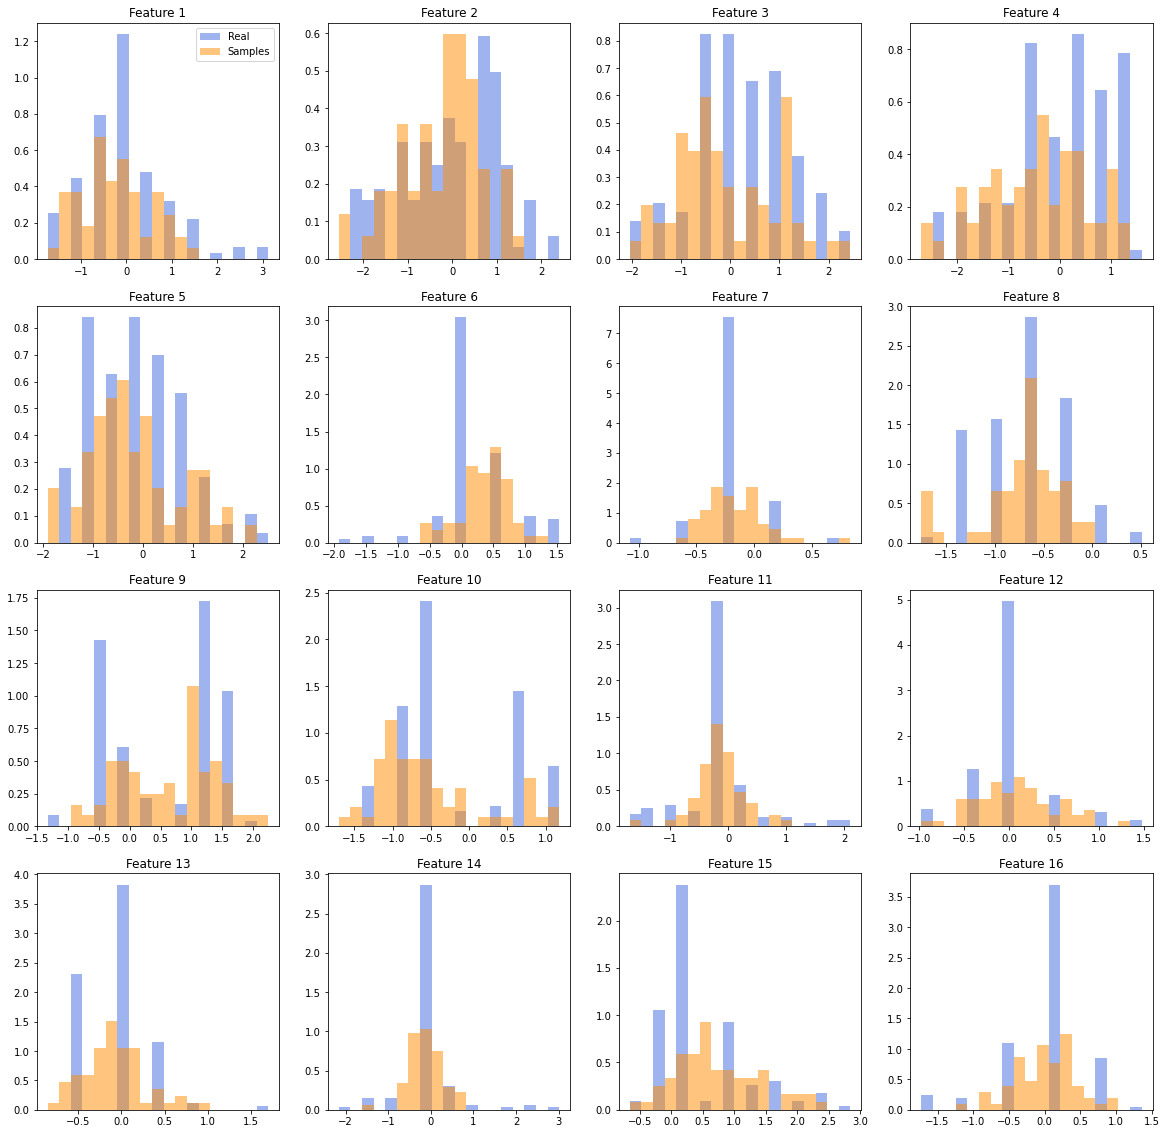

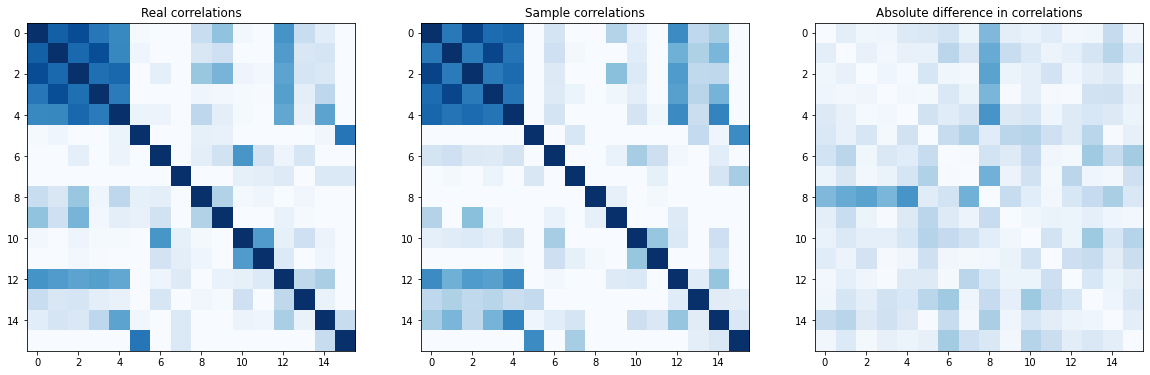

Class O


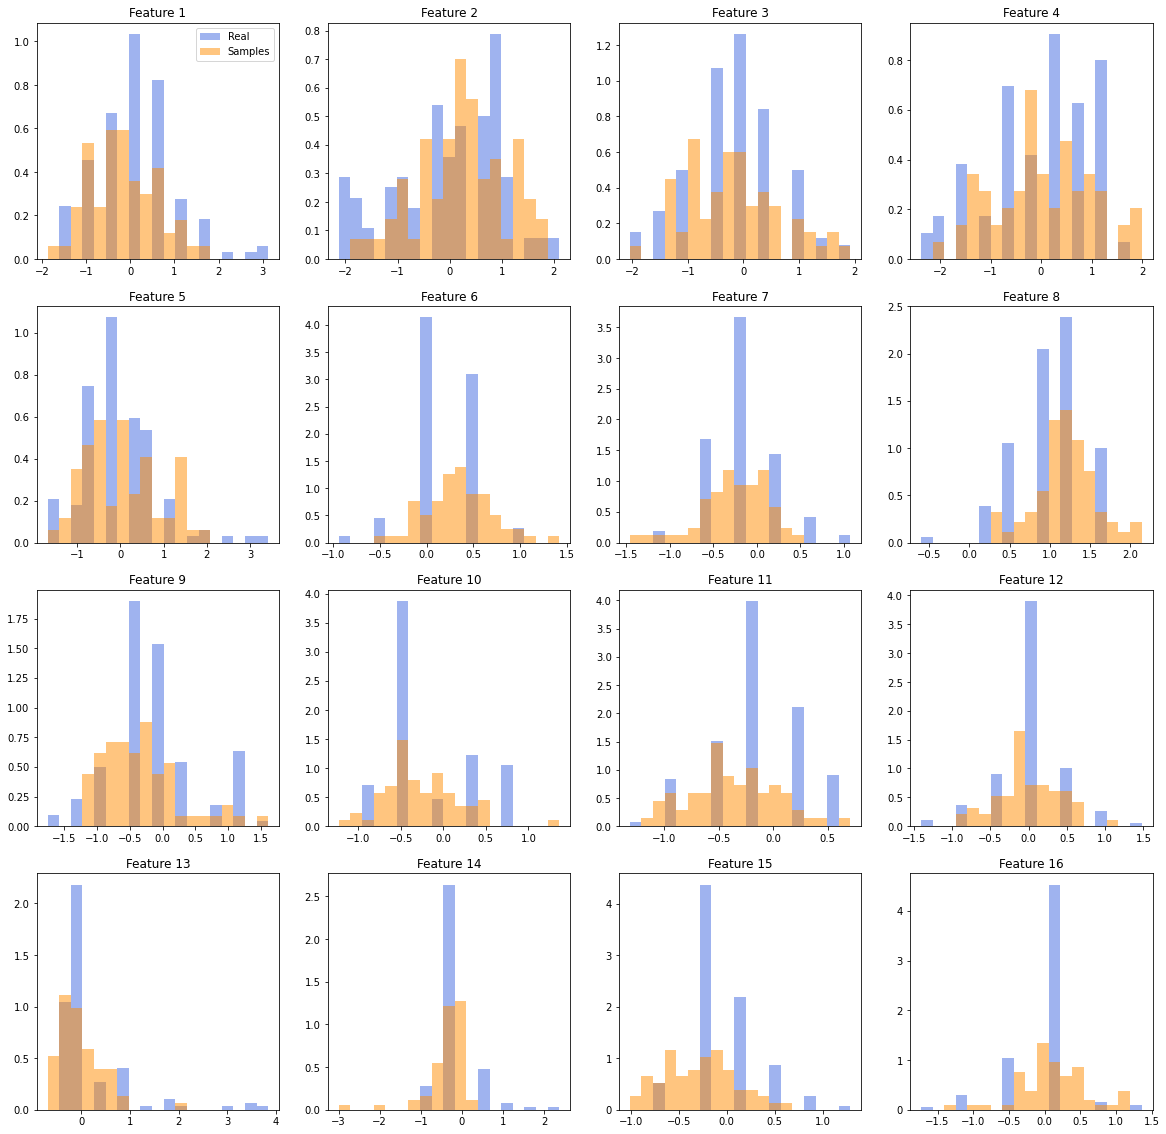

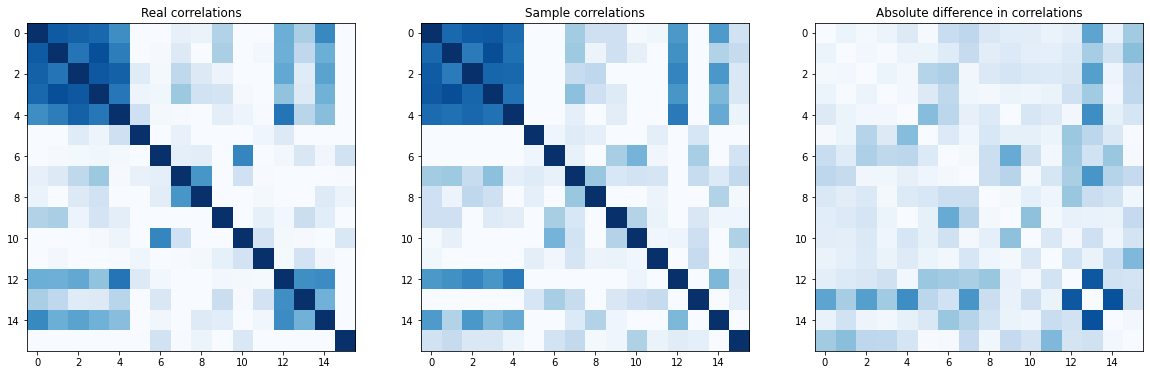

Class Q


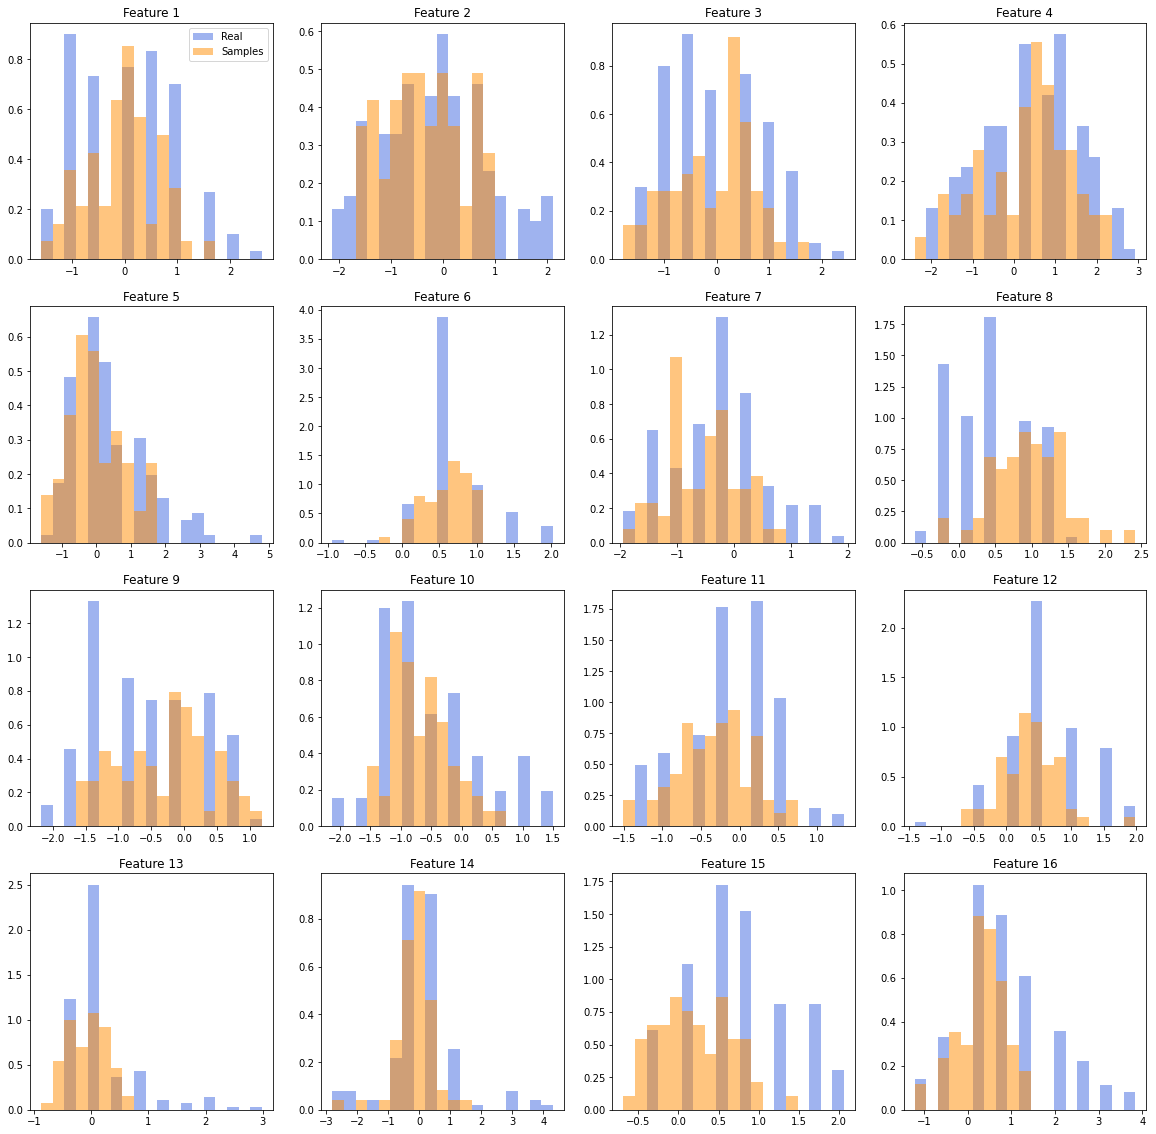

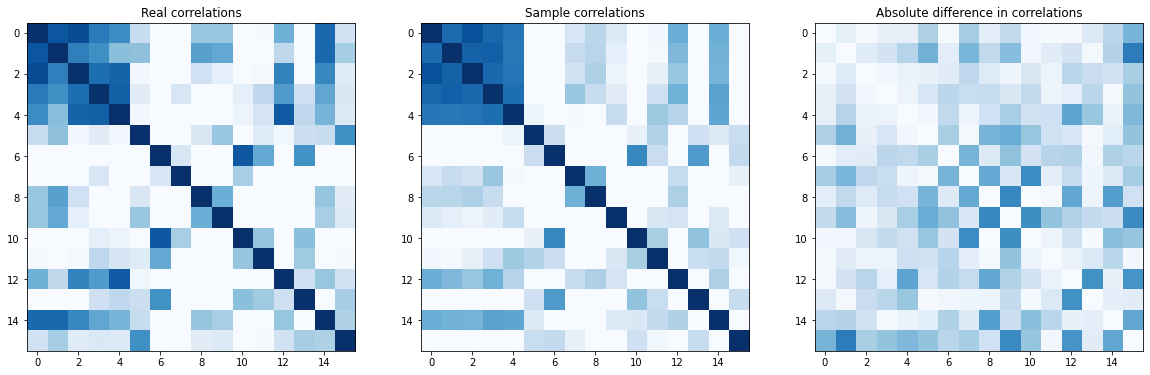

In [10]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.numpy())
    targets.append(y.numpy())
data = np.concatenate([data])
targets = np.concatenate([targets])

for class_to_sample in classes:
    print("Class %s" % class_to_letter[class_to_sample])
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    num_features = input_shape[0]
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, i]
        sample_vals = sample[:, i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % (i + 1))
    ax[0][0].legend()
    plt.show()

    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i in range(num_features):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, i], real[:, j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, i], sample[:, j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

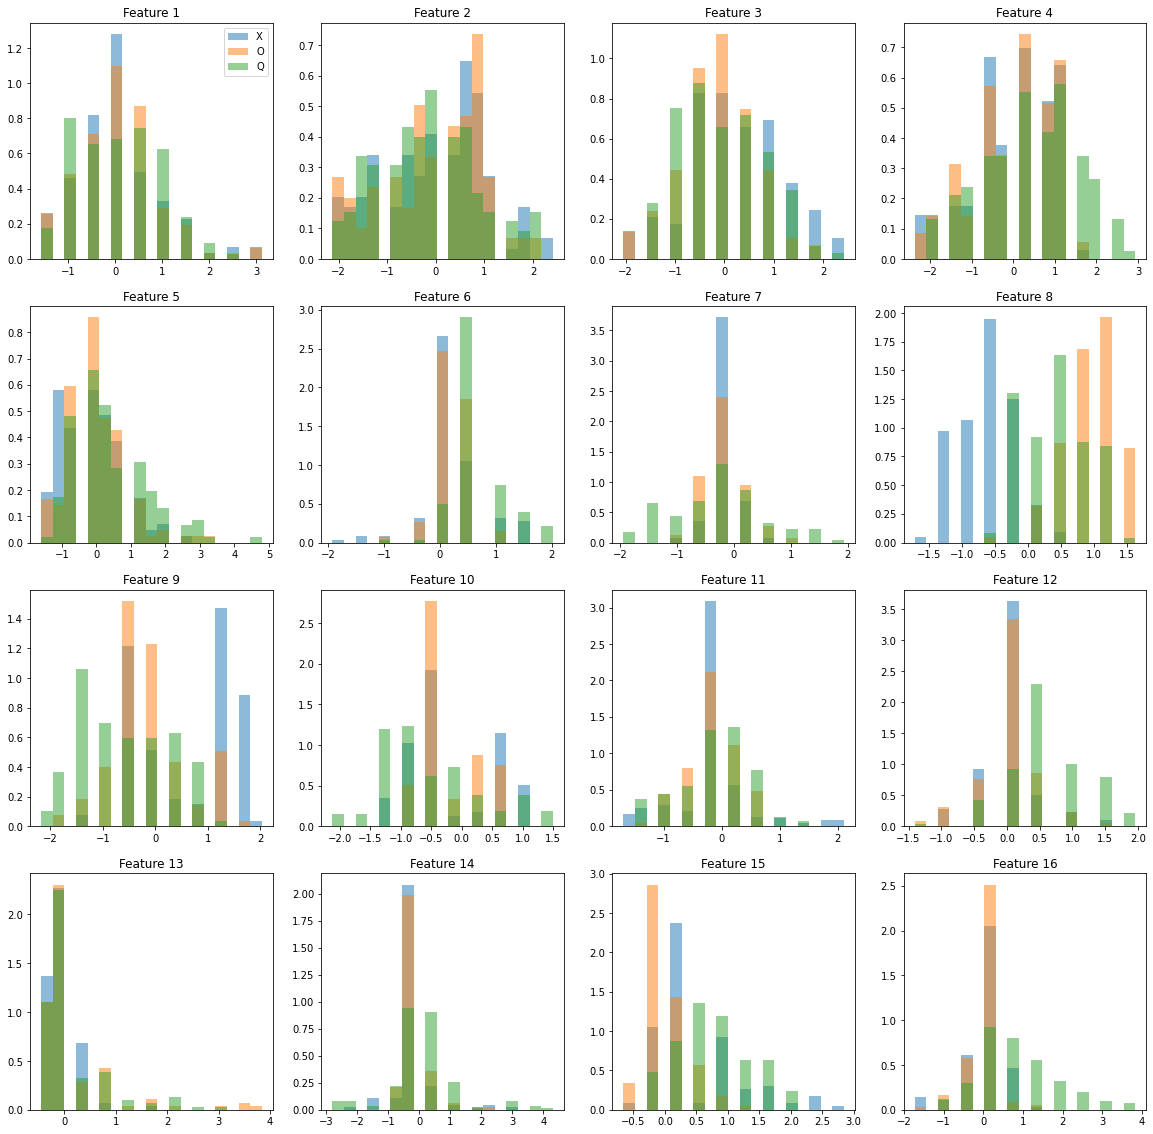

In [13]:
num_features = input_shape[0]
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

for i in range(num_features):
    r, c = i // num_cols, i % num_cols
    data_to_plot = {}
    for class_to_sample in classes:
        data_to_plot[class_to_sample] = data[targets == class_to_sample][:, i]
    all_vals = np.concatenate(list(data_to_plot.values()))
    bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
    for class_to_sample in classes:
        ax[r][c].hist(
            data_to_plot[class_to_sample], bins=bins, label=class_to_letter[class_to_sample],
            density=True, alpha=0.5
        )
    ax[r][c].set_title("Feature %d" % (i + 1))
ax[0][0].legend()
plt.show()

**Diffusing from one class to another**

In [11]:
# orig_4 = torch.stack([
#     torch.tensor(dataset[i][0], device=DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
# ])
# orig_9 = torch.stack([
#     torch.tensor(dataset[i][0], device=DEVICE) for i in 
#     np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
# ])

# time_steps = 10
# all_t = np.linspace(0, branch_time_4_9, time_steps)
# forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
# backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
# forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
# backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
# orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
# for t_i, t in enumerate(all_t):
#     forward_4_to_9[t_i] = sde.forward(
#         orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
#     )[0].cpu().numpy()
#     forward_9_to_4[t_i] = sde.forward(
#         orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
#     )[0].cpu().numpy()

# all_t_flip = np.flip(all_t)
# last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
# last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
# for t_i in range(len(all_t_flip) - 1):
#     last_4_to_9 = generate.generate_continuous_branched_samples(
#         model, sde, 9, class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_4.shape[0], initial_samples=last_4_to_9,
#         num_steps=50
#     )
#     backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
#     last_9_to_4 = generate.generate_continuous_branched_samples(
#         model, sde, 4, class_time_to_branch_tensor, sampler="pc",
#         t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
#         num_samples=orig_9.shape[0], initial_samples=last_9_to_4,
#         num_steps=50
#     )
#     backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
# print("4 to 9")
# for t_i, t in enumerate(all_t):
#     plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
# for t_i, t in enumerate(all_t_flip[1:]):
#     plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

# print("9 to 4")
# for t_i, t in enumerate(all_t):
#     plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
# for t_i, t in enumerate(all_t_flip[1:]):
#     plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))